### Codes for reproduce the results in figure 3

### Figure 3B, 3C

In [1]:
import numpy as np
import pandas as pd
import os,re,sys,random
from scipy import interp
import multiprocessing.pool
from allennlp.commands.elmo import ElmoEmbedder
import torch
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras import backend as K
K.clear_session()
from keras import layers, optimizers, models, regularizers
from keras.layers import *
from keras.models import *
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

class Elmo_embedder():
    def __init__(self, model_dir="/public/home/hxu6/projects/degron/DegronsDB/model/uniref50_v2", weights="weights.hdf5",
                 options="options.json", threads=1000):
        if threads == 1000:
            torch.set_num_threads(multiprocessing.cpu_count() // 2)
        else:
            torch.set_num_threads(threads)

        self.model_dir = Path(model_dir)
        self.weights = self.model_dir / weights
        self.options = self.model_dir / options
        self.seqvec = ElmoEmbedder(self.options, self.weights, cuda_device=-1)

    def elmo_embedding(self, x, start=None, stop=None):
        assert start is None and stop is None, "deprecated to use start stop, please trim seqs beforehand"

        if type(x[0]) == str:
            x = np.array([list(i.upper()) for i in x])
        embedding = self.seqvec.embed_sentences(x)
        X_parsed = []
        for i in embedding:
            X_parsed.append(i.mean(axis=0))
        return X_parsed

Using TensorFlow backend.


In [2]:
elmo_embedder = Elmo_embedder(threads=60)       

In [3]:
def build_model(nodes, dropout, seq_length, weight_decay_lstm=1e-6, weight_decay_dense=1e-3):
    
    embedding_input = Input(shape=(seq_length, 1024))
    
    left1 = Conv1D(128, 8, padding='valid',activation='relu',strides=1)(embedding_input)
    left1 = MaxPooling1D(pool_size=2, strides=None, padding='valid')(left1) 
    
    left2 = Bidirectional(LSTM(nodes, input_shape=(seq_length, 1024), return_sequences=True, dropout=dropout,
                    recurrent_dropout=0.2, kernel_regularizer=l2(weight_decay_lstm),
                    recurrent_regularizer=l2(weight_decay_lstm), bias_regularizer=l2(weight_decay_lstm)))(
        embedding_input)
                    
    left2 = Bidirectional(LSTM(nodes // 2, dropout=dropout, return_sequences=True, recurrent_dropout=0.5,
                    kernel_regularizer=l2(weight_decay_lstm), recurrent_regularizer=l2(weight_decay_lstm),
                    bias_regularizer=l2(weight_decay_lstm)))(left2)                
                    
    left1 = Dense(nodes)(left1)
    left1 = LeakyReLU(alpha=0.01)(left1)
    out_left1 = Flatten()(left1)
    
    left2 = Dense(nodes)(left2)
    left2 = LeakyReLU(alpha=0.01)(left2)
    out_left2 = Flatten()(left2)
    

    seq_input = Input(shape=(seq_length,))
    right = Embedding(27, 10, input_length=seq_length)(seq_input)
    right = Bidirectional(
        LSTM(nodes, return_sequences=True, dropout=dropout,
                    recurrent_dropout=0.2, kernel_regularizer=l2(weight_decay_lstm),
                    recurrent_regularizer=l2(weight_decay_lstm), bias_regularizer=l2(weight_decay_lstm)))(right)
    
    right = Dense(nodes)(right)
    right = LeakyReLU(alpha=0.01)(right)
    out_right = Flatten()(right)

    hidden = concatenate([out_left1, out_left2, out_right])

    hidden = Dense(nodes, kernel_regularizer=l2(weight_decay_dense), bias_regularizer=l2(weight_decay_dense))(
        hidden)

    hidden = LeakyReLU(alpha=0.01)(hidden)

    out = Dense(1, activation='sigmoid', kernel_regularizer=l2(weight_decay_dense),
                       bias_regularizer=l2(weight_decay_dense))(hidden)

    model = models.Model(inputs=[embedding_input, seq_input], outputs=out)

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [4]:
def draw_cv_roc_and_pr_curve_DL(cv, X1, X2, y, fileroc):
    
    nodes = 20
    shift = 14
    dropout = 0.5
    seq_length = 29
    
    tprs = []
    aucs = []

    mean_fpr = np.linspace(0, 1, 100)
    
    y_real = []
    y_proba = []
    test_ind = []
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)

    font1 = {'family' : 'Times New Roman',
            'weight' : 'normal',
            'size'   : 16}
    figsize=5, 5
    
    ########ROC_figure
    figure1, ax1 = plt.subplots(figsize=figsize)
    ax1.tick_params(labelsize=14)
    labels = ax1.get_xticklabels() + ax1.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]  

    i = 0
    for train, test in cv.split(X1, y):
        
        classifier = build_model(nodes, dropout=dropout, seq_length=seq_length)
        
        mc = ModelCheckpoint(fileroc + '/model_%s.h5' % str(i), monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True, save_best_only=True)
        weights = compute_class_weight('balanced',classes=np.arange(2),y=np.squeeze(y[train]))

        train_input = [X1[train], X2[train]]
        test_input = [X1[test], X2[test]]
            
        classifier.fit(train_input,
                y[train],
                batch_size=64,
                epochs = 100,
                shuffle=True,
                callbacks=[es, mc],
                validation_data=(test_input, y[test]),
                class_weight = {i:weights[i] for i in range(len(weights))},
                verbose=1)
                       
        classifier.load_weights(fileroc + '/model_%s.h5' % str(i))
        probas_ = classifier.predict(test_input)       
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax1.plot(fpr, tpr, lw=1.5, alpha=0.5,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
        y_real.append(y[test])
        y_proba.append(probas_)

        del classifier
        
        i += 1
    
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)  
    
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=3.5, color='r',
                label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=3.5, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate (FPR)',fontsize=14)
    ax1.set_ylabel('True Positive Rate (TPR)',fontsize=14)
    ax1.legend(loc="lower right",fontsize=10)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    figure1.savefig(fileroc + '/' + 'CV5_roc.png', dpi=300, bbox_inches = 'tight')
    

In [5]:
X_train_local = np.load('/public/home/hxu6/projects/degron/DegronsDB/data_patterns/all_train_embedding.npy', allow_pickle = True) # Please change the "train_embedding" path
all_train_embedding = []
all_train_number_vec = []
all_train_lable = []
for hit in X_train_local:
    all_train_embedding.append(hit[2])
    all_train_number_vec.append(hit[3])
    all_train_lable.append(hit[-1])

train_x = np.array(all_train_embedding)
train_x1 = np.array(all_train_number_vec)
y = np.array(all_train_lable)

indices = np.arange(train_x.shape[0]) # help for check the index after split

np.random.seed(202310)
permutation = np.random.permutation(train_x.shape[0])
train_x = train_x[permutation, :, :]
train_x1 = train_x1[permutation, :]
train_x1 = train_x1.astype(np.float32)

y1 = y[permutation]
y1 = y1.astype(np.int)

X_train1, X_test1, y_train1, y_test1, idx11, idx21 = train_test_split(train_x, y1, indices, test_size=0.1, random_state=202309, stratify=y)
X_train2, X_test2, y_train2, y_test2, idx12, idx22 = train_test_split(train_x1, y1, indices, test_size=0.1, random_state=202309, stratify=y)


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2024-06-20 13:55:22.816983: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/gridview//pbs/dispatcher/lib:/opt/gridview//pbs/dispatcher/lib::/usr/local/lib64:/usr/local/lib:/usr/local/lib64:/usr/local/lib
2024-06-20 13:55:22.817024: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-20 13:55:22.817047: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (node4): /proc/driver/nvidia/version does not exist
2024-06-20 13:55:22.817990: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-06-20 13:55:22.848944: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400000000 Hz
2024-06-20 


Train on 1245 samples, validate on 312 samples
Epoch 1/100
1245/1245 [==============================] - 4s 3ms/step - loss: 0.7342 - accuracy: 0.5229 - val_loss: 0.6360 - val_accuracy: 0.8173

Epoch 00001: val_accuracy improved from -inf to 0.81731, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_0.h5
Epoch 2/100
1245/1245 [==============================] - 2s 1ms/step - loss: 0.6741 - accuracy: 0.6723 - val_loss: 0.5523 - val_accuracy: 0.8365

Epoch 00002: val_accuracy improved from 0.81731 to 0.83654, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_0.h5
Epoch 3/100
1245/1245 [==============================] - 2s 1ms/step - loss: 0.5739 - accuracy: 0.7060 - val_loss: 0.4700 - val_accuracy: 0.8237

Epoch 00003: val_accuracy did not improve from 0.83654
Epoch 4/100
1245/1245 [==============================] - 2s 1ms/step - loss: 0.4763 - accuracy: 0.7863 - val_loss: 0.3756 - val_

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 1245 samples, validate on 312 samples
Epoch 1/100
1245/1245 [==============================] - 4s 3ms/step - loss: 0.7200 - accuracy: 0.5133 - val_loss: 0.7033 - val_accuracy: 0.6218

Epoch 00001: val_accuracy improved from -inf to 0.62179, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_1.h5
Epoch 2/100
1245/1245 [==============================] - 1s 1ms/step - loss: 0.6646 - accuracy: 0.6450 - val_loss: 0.5450 - val_accuracy: 0.8269

Epoch 00002: val_accuracy improved from 0.62179 to 0.82692, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_1.h5
Epoch 3/100
1245/1245 [==============================] - 1s 1ms/step - loss: 0.5542 - accuracy: 0.7719 - val_loss: 0.4821 - val_accuracy: 0.8013

Epoch 00003: val_accuracy did not improve from 0.82692
Epoch 4/100
1245/1245 [==============================] - 1s 1ms/step - loss: 0.4218 - accuracy: 0.8273 - val_loss: 0.5011 - val_a

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 1246 samples, validate on 311 samples
Epoch 1/100
1246/1246 [==============================] - 4s 3ms/step - loss: 0.7068 - accuracy: 0.5586 - val_loss: 0.7567 - val_accuracy: 0.4244

Epoch 00001: val_accuracy improved from -inf to 0.42444, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_2.h5
Epoch 2/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.6051 - accuracy: 0.6934 - val_loss: 0.5777 - val_accuracy: 0.7524

Epoch 00002: val_accuracy improved from 0.42444 to 0.75241, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_2.h5
Epoch 3/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.4949 - accuracy: 0.8058 - val_loss: 0.6667 - val_accuracy: 0.6109

Epoch 00003: val_accuracy did not improve from 0.75241
Epoch 4/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.3820 - accuracy: 0.8620 - val_loss: 0.4923 - val_a

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 1246 samples, validate on 311 samples
Epoch 1/100
1246/1246 [==============================] - 4s 4ms/step - loss: 0.7188 - accuracy: 0.5474 - val_loss: 0.6484 - val_accuracy: 0.8360

Epoch 00001: val_accuracy improved from -inf to 0.83601, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_3.h5
Epoch 2/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.6185 - accuracy: 0.7352 - val_loss: 0.5030 - val_accuracy: 0.8103

Epoch 00002: val_accuracy did not improve from 0.83601
Epoch 3/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.4916 - accuracy: 0.8194 - val_loss: 0.6805 - val_accuracy: 0.6592

Epoch 00003: val_accuracy did not improve from 0.83601
Epoch 4/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.4061 - accuracy: 0.8210 - val_loss: 0.6438 - val_accuracy: 0.6656

Epoch 00004: val_accuracy did not improve from 0.83601
Epoch 5/100
1246/1246 [=================

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 1246 samples, validate on 311 samples
Epoch 1/100
1246/1246 [==============================] - 5s 4ms/step - loss: 0.7317 - accuracy: 0.5209 - val_loss: 0.5244 - val_accuracy: 0.8264

Epoch 00001: val_accuracy improved from -inf to 0.82637, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_4.h5
Epoch 2/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.6710 - accuracy: 0.6348 - val_loss: 0.7049 - val_accuracy: 0.5370

Epoch 00002: val_accuracy did not improve from 0.82637
Epoch 3/100
1246/1246 [==============================] - 2s 1ms/step - loss: 0.5543 - accuracy: 0.8018 - val_loss: 0.7357 - val_accuracy: 0.5209

Epoch 00003: val_accuracy did not improve from 0.82637
Epoch 4/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.4953 - accuracy: 0.7376 - val_loss: 0.4760 - val_accuracy: 0.7942

Epoch 00004: val_accuracy did not improve from 0.82637
Epoch 5/100
1246/1246 [=================

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


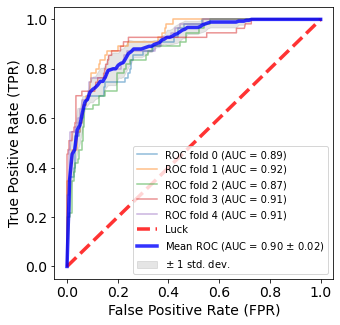

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=202310) 
fileroc = '/public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test' # Please change the "save" path
if not os.path.isdir(fileroc):
    os.makedirs(fileroc) 
    
draw_cv_roc_and_pr_curve_DL(cv, X_train1, X_train2, y_train1, fileroc)    

### Figure 3D

In [7]:
import sys, os, math, tempfile, datetime, time, copy, re
import numpy as np
import pandas as pd
from allennlp.commands.elmo import ElmoEmbedder
from collections import Counter, defaultdict
from keras.layers import Input, Dense
from keras.models import Model 
from keras.models import model_from_json
from math import log
from pathlib import Path
import pickle
from scipy.stats import percentileofscore
from sklearn.preprocessing import LabelEncoder
import argparse
import torch
import multiprocessing.pool
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict  
from sklearn.metrics import accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score, recall_score, precision_score

In [8]:
shift, slicesize = 14, 29
path_sequences = "./supporting_file/uniprot_seq.tsv"
df_sequences = pd.read_csv(path_sequences,sep=",")
d_seqs = {}
for index,row in df_sequences.iterrows():
    d_seqs[row["Entry_Isoform"]] = row["Sequence"]

def import_model():
    json_f = open("./models/degron_DL.json", 'r')
    loaded_model_json = json_f.read()
    json_f.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('./models/degron_DL.h5')
    return loaded_model

def AA_encoding(seq_extended):
    amino = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-"
    encoder = LabelEncoder()
    encoder.fit(list(amino))
    seq_transformed = np.array(
        list(map(encoder.transform, np.array([list(i.upper()) for i in seq_extended]))))   
    return seq_transformed[0]

def calculate_metrics(gt, pred_score):
        
    scores_two = np.array([[1-s, s] for s in pred_score])
    pred = np.argmax(scores_two,axis = 1)

    confusion = confusion_matrix(gt, pred)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    P = TP / float(TP + FP)
    R = TP / float(TP + FN)

    auc = roc_auc_score(gt,pred_score)
    PPV = TP / float(TP + FP)
    accuracy = accuracy_score(gt,pred)
    recal = recall_score(gt,pred)
    precision = precision_score(gt,pred)
    F1_score = (2*recal*precision)/(recal+precision)
    auprc = average_precision_score(gt,pred_score)
    
    return auc, auprc, accuracy, recal, F1_score

In [9]:
class Elmo_embedder():
    def __init__(self, model_dir="./models/uniref50_v2", weights="weights.hdf5",
                 options="options.json", threads=100): 
        if threads == 100:
            torch.set_num_threads(multiprocessing.cpu_count() // 2)
        else:
            torch.set_num_threads(threads)

        self.model_dir = Path(model_dir)
        self.weights = self.model_dir / weights
        self.options = self.model_dir / options
        self.seqvec = ElmoEmbedder(self.options, self.weights, cuda_device=-1)

    def elmo_embedding(self, x, start=None, stop=None):
        assert start is None and stop is None, "deprecated to use start stop, please trim seqs beforehand"

        if type(x[0]) == str:
            x = np.array([list(i.upper()) for i in x])
        embedding = self.seqvec.embed_sentences(x)
        X_parsed = []
        for i in embedding:
            X_parsed.append(i.mean(axis=0))
        return X_parsed
    
elmo_embedder = Elmo_embedder(threads=60)   
loaded_model = import_model() 

In [10]:
test_file = './data/test_properties.tsv'
df_matches = pd.read_csv(test_file, sep="\t")

X_local, all_seq_transformed, all_seq_elmo_embedding = [], [], []
m = 0
for index,row in df_matches.iterrows():
    m = m + 1
    seq_local = d_seqs[row['Entry']]
    seq_len = len(seq_local)
    seq_local = seq_local.upper()
    seq_local_list = np.array(list(seq_local))

    X_embedding = elmo_embedder.elmo_embedding(seq_local_list)
    protein_pad_global = np.zeros((seq_len + (shift * 2), 1024), dtype=np.float32)

    for i in range(0, seq_len, 1):
        protein_pad_global[i + (shift)] = X_embedding[i]

    protein_pad_local = ["-"] * (seq_len + (shift * 2))
    for i in range(0, seq_len, 1):
        protein_pad_local[i + (shift)] = seq_local[i]
    protein_pad_local = "".join(protein_pad_local)

    start_origin = int(row['Start'])-1
    stop_origin = int(row['End'])
    motif = row['DEGRON']
    degron = row['Hit']
    start = start_origin + shift
    stop = stop_origin + shift
    median_pos = (start+stop-1)//2
    slice_start = median_pos - slicesize // 2
    slice_stop = slice_start + slicesize
    query_seq = protein_pad_local[slice_start:slice_stop]
    seq_transformed = AA_encoding([query_seq])
    all_seq_transformed.append(seq_transformed)
    seq_elmo_embedding = protein_pad_global[slice_start:slice_stop]
    all_seq_elmo_embedding.append(seq_elmo_embedding)
    
    print(m)
    
probs_p = loaded_model.predict([all_seq_elmo_embedding, all_seq_transformed]) 
probs_p1 = [float(i) for i in probs_p]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [11]:
simulated = './supporting_file/simulated_degron2.csv'
df_simulated = pd.read_csv(simulated)

results = []
for s in range(10):
    df_simulated_s = df_simulated.sample(n=len(df_matches), random_state=s+1)
    X_local, all_seq_transformed, all_seq_elmo_embedding = [], [], []
    m = 0
    for index,row in df_simulated_s.iterrows():
        m = m + 1
        seq_local = d_seqs[row['Entry']]
        seq_len = len(seq_local)
        seq_local = seq_local.upper()
        seq_local_list = np.array(list(seq_local))

        X_embedding = elmo_embedder.elmo_embedding(seq_local_list)
        protein_pad_global = np.zeros((seq_len + (shift * 2), 1024), dtype=np.float32)

        for i in range(0, seq_len, 1):
            protein_pad_global[i + (shift)] = X_embedding[i]

        protein_pad_local = ["-"] * (seq_len + (shift * 2))
        for i in range(0, seq_len, 1):
            protein_pad_local[i + (shift)] = seq_local[i]
        protein_pad_local = "".join(protein_pad_local)

        start_origin = int(row['START'])-1
        stop_origin = int(row['END'])
        motif = row['DEGRON']
        start = start_origin + shift
        stop = stop_origin + shift
        median_pos = (start+stop-1)//2
        slice_start = median_pos - slicesize // 2
        slice_stop = slice_start + slicesize
        query_seq = protein_pad_local[slice_start:slice_stop]
        seq_transformed = AA_encoding([query_seq])
        all_seq_transformed.append(seq_transformed)
        seq_elmo_embedding = protein_pad_global[slice_start:slice_stop]
        all_seq_elmo_embedding.append(seq_elmo_embedding)
                
    print(s)
    
    probs_n = loaded_model.predict([all_seq_elmo_embedding, all_seq_transformed]) 
    probs_n1 = [float(i) for i in probs_n]
    
    predicted_probs = np.concatenate((probs_p1,probs_n1)) 
    true_labels = np.concatenate((np.ones((len(probs_p1),), dtype=np.int),np.zeros((len(probs_n1),), dtype=np.int)), axis=0)
    
    temp={"predicted_probs" : predicted_probs,
            "true_labels" : true_labels,
            "symbol" : 'test_n%s' % str(s+1),
            }
    temp1=pd.DataFrame(temp)
    
    results.append(temp1)
    
df_result_metadegron_d = pd.concat(results, ignore_index=True)

0


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1
2
3
4
5
6
7
8
9


In [12]:
classifier_XGBoost  = "./models/classifier_XGBoost.pickle"
out_file = './prediction'
test_data = './data/test_properties.tsv'
df_properties = pd.read_csv(test_data, sep="\t")

covariates = ['solvent_accessibility', 'disorder', 'conservative_score', 'coiled_coil',
              'anchoring_score', 'flanking_ptms', 'flanking_ub_lysine', 
              'a_helix', 'flexibility',  'structured_domain',  ]

pred =["ASA_SCORE","DSS_SCORE","FCONS_SCORE","COIL",
       "ANCHOR_SCORE","nflanking_ptms","nflanking_ub_lysines",
       "HELIX","RIG_SCORE","Domain_pfam"]

clf = pickle.load(open(classifier_XGBoost, "rb"))
p_probs = clf.predict_proba(df_properties[covariates])
probs_p1 = [l[1] for l in p_probs]

In [13]:
simulated = './supporting_file/simulated_degron2.csv'
df_simulated = pd.read_csv(simulated)
results = []
for s in range(10):
    df_simulated_s = df_simulated.sample(n=len(probs_p1), random_state=s+1)
    negatives = df_simulated_s.copy()
    n_probs = clf.predict_proba(negatives[pred])
    probs_n1 = [l[1] for l in n_probs]

    predicted_probs = np.concatenate((probs_p1,probs_n1)) 
    true_labels = np.concatenate((np.ones((len(probs_p1),), dtype=np.int),np.zeros((len(probs_n1),), dtype=np.int)), axis=0)
    
    temp={"predicted_probs" : predicted_probs,
            "true_labels" : true_labels,
            "symbol" : 'test_n%s' % str(s+1),
            }
    temp1=pd.DataFrame(temp)
    
    results.append(temp1)
    
df_result_metadegron_x = pd.concat(results, ignore_index=True)

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


In [14]:
results = []
filefold = './supporting_file/Degpred_result.csv'
Degpred_RES = pd.read_csv(filefold)

for symbol, grp in Degpred_RES.groupby("symbol"):
    auc, auprc, accuracy, recal, F1_score = calculate_metrics(grp['true_labels'], grp['predicted_probs'])
    results.append([auc, 'auc', symbol])
    results.append([auprc, 'auprc', symbol])
    results.append([accuracy, 'accuracy', symbol])
    results.append([recal, 'recall', symbol])
    results.append([F1_score, 'F1_score', symbol])
    
Degpred_pred=pd.DataFrame(results, columns=['values','metrics','times'])   
Degpred_pred['tools'] = 'Degpred' 

results = []
for symbol, grp in df_result_metadegron_d.groupby("symbol"):
    auc, auprc, accuracy, recal, F1_score = calculate_metrics(grp['true_labels'], grp['predicted_probs'])
    results.append([auc, 'auc', symbol])
    results.append([auprc, 'auprc', symbol])
    results.append([accuracy, 'accuracy', symbol])
    results.append([recal, 'recall', symbol])
    results.append([F1_score, 'F1_score', symbol])
    
MetaDegron_D_pred=pd.DataFrame(results, columns=['values','metrics','times'])   
MetaDegron_D_pred['tools'] = 'MetaDegron-D' 

results = []
for symbol, grp in df_result_metadegron_x.groupby("symbol"):
    auc, auprc, accuracy, recal, F1_score = calculate_metrics(grp['true_labels'], grp['predicted_probs'])
    results.append([auc, 'auc', symbol])
    results.append([auprc, 'auprc', symbol])
    results.append([accuracy, 'accuracy', symbol])
    results.append([recal, 'recall', symbol])
    results.append([F1_score, 'F1_score', symbol])
    
MetaDegron_X_pred=pd.DataFrame(results, columns=['values','metrics','times'])   
MetaDegron_X_pred['tools'] = 'MetaDegron-X' 

df_pred = pd.concat([Degpred_pred, MetaDegron_D_pred, MetaDegron_X_pred])


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


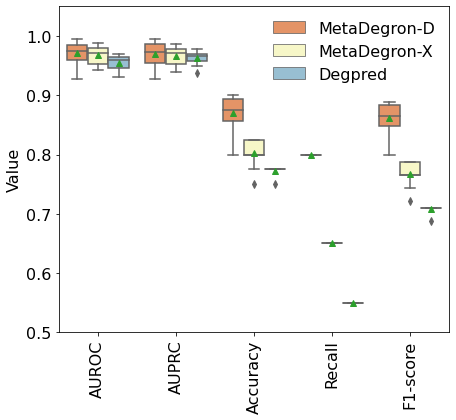

In [15]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=7, 6
figure, ax = plt.subplots(figsize=figsize)
plt.tick_params(labelsize=16)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

sns.boxplot(x="metrics", y="values", hue='tools',
                order=['auc','auprc','accuracy','recall','F1_score'],
                hue_order=['MetaDegron-D','MetaDegron-X','Degpred'],
                data=df_pred, palette='RdYlBu',showmeans=True)

plt.xlabel('', font1, fontsize=16) 
plt.ylabel('Value', font1, fontsize=16)
plt.xticks(rotation=90)
ax.set_ylim(0.5,1.05)
ax.set_xticklabels(["AUROC", "AUPRC", "Accuracy", "Recall", "F1-score"])
plt.legend(frameon=False, prop=font1)


### Figure 3E-I

In [18]:
import numpy as np
import h5py
import pandas as pd
from sklearn.manifold import TSNE
from keras import backend as K
from keras.models import load_model
import re, sys
import heapq
import string
import random
from os import remove
from copy import deepcopy
from tempfile import gettempdir
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import Model as KModel
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import Input, LSTM, GRU, Bidirectional, concatenate
from keras.constraints import max_norm
from keras.optimizers import Adam
from keras.initializers import RandomUniform
from keras.utils.np_utils import *
from keras.optimizers import Adam
from keras.initializers import RandomUniform, RandomNormal, glorot_uniform, glorot_normal
from keras.models import Model
from keras.layers.core import  Dense, Dropout, Permute, Lambda
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.models import load_model
from keras import regularizers
from keras.constraints import maxnorm
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, Input
from keras.layers.merge import multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
import os
from sklearn.metrics import roc_curve, auc
from keras.regularizers import l1, l2, l1_l2
from keras import regularizers
from keras.callbacks import ModelCheckpoint,TensorBoard
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import umap
np.random.seed(1234)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras import layers, optimizers, models

In [19]:
def build_model(nodes, dropout, seq_length, weight_decay_lstm=1e-6, weight_decay_dense=1e-3):
    
    embedding_input = Input(shape=(seq_length, 1024))
    
    left1 = Conv1D(128, 8, padding='valid',activation='relu',strides=1)(embedding_input)
    left1 = MaxPooling1D(pool_size=2, strides=None, padding='valid')(left1) 
    
    left2 = Bidirectional(LSTM(nodes, input_shape=(seq_length, 1024), return_sequences=True, dropout=dropout,
                    recurrent_dropout=0.2, kernel_regularizer=l2(weight_decay_lstm),
                    recurrent_regularizer=l2(weight_decay_lstm), bias_regularizer=l2(weight_decay_lstm)))(
        embedding_input)
                    
    left2 = Bidirectional(LSTM(nodes // 2, dropout=dropout, return_sequences=True, recurrent_dropout=0.5,
                    kernel_regularizer=l2(weight_decay_lstm), recurrent_regularizer=l2(weight_decay_lstm),
                    bias_regularizer=l2(weight_decay_lstm)))(left2)                
                    
    left1 = Dense(nodes)(left1)
    left1 = LeakyReLU(alpha=0.01)(left1)
    out_left1 = Flatten()(left1)
    
    left2 = Dense(nodes)(left2)
    left2 = LeakyReLU(alpha=0.01)(left2)
    out_left2 = Flatten()(left2)
    

    seq_input = Input(shape=(seq_length,))
    right = Embedding(27, 10, input_length=seq_length)(seq_input)
    right = Bidirectional(
        LSTM(nodes, return_sequences=True, dropout=dropout,
                    recurrent_dropout=0.2, kernel_regularizer=l2(weight_decay_lstm),
                    recurrent_regularizer=l2(weight_decay_lstm), bias_regularizer=l2(weight_decay_lstm)))(right)
    
    right = Dense(nodes)(right)
    right = LeakyReLU(alpha=0.01)(right)
    out_right = Flatten()(right)

    hidden = concatenate([out_left1, out_left2, out_right])

    hidden = Dense(nodes, kernel_regularizer=l2(weight_decay_dense), bias_regularizer=l2(weight_decay_dense))(
        hidden)

    hidden = LeakyReLU(alpha=0.01)(hidden)

    out = Dense(1, activation='sigmoid', kernel_regularizer=l2(weight_decay_dense),
                       bias_regularizer=l2(weight_decay_dense))(hidden)

    model = models.Model(inputs=[embedding_input, seq_input], outputs=out)

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [20]:
nodes = 20
shift = 14
dropout = 0.5
seq_length = 29

json_f = open("./models/degron_DL.json", 'r')
loaded_model_json = json_f.read()
json_f.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('./models/degron_DL.h5')

In [23]:
X_train_local = np.load('/public/home/hxu6/projects/degron/DegronsDB/data_patterns/all_train_embedding.npy', allow_pickle = True) # Please change the "train_embedding" path
all_train_embedding = []
all_train_number_vec = []
all_train_lable = []
for hit in X_train_local:
    all_train_embedding.append(hit[2])
    all_train_number_vec.append(hit[3])
    all_train_lable.append(hit[-1])

train_x = np.array(all_train_embedding)
train_x1 = np.array(all_train_number_vec)
y = np.array(all_train_lable)

indices = np.arange(train_x.shape[0]) # help for check the index after split

np.random.seed(202310)
permutation = np.random.permutation(train_x.shape[0])
train_x = train_x[permutation, :, :]
train_x1 = train_x1[permutation, :]
train_x1 = train_x1.astype(np.float32)

y1 = y[permutation]
y1 = y1.astype(np.int)

# y1 = to_categorical(y)
X_train1, X_test1, y_train1, y_test1, idx11, idx21 = train_test_split(train_x, y1, indices, test_size=0.1, random_state=202309, stratify=y)
X_train2, X_test2, y_train2, y_test2, idx12, idx22 = train_test_split(train_x1, y1, indices, test_size=0.1, random_state=202309, stratify=y)

train_input = [X_train1, X_train2]
test_input = [X_test1, X_test2]
y_train_input = y_train1
y_test_input = y_test1

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0    1282
1     275
Name: label, dtype: int64
UMAP start...
UMAP done...


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


0    1282
1     275
Name: label, dtype: int64
UMAP start...
UMAP done...


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


0    1282
1     275
Name: label, dtype: int64
UMAP start...
UMAP done...


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


0    1282
1     275
Name: label, dtype: int64
UMAP start...
UMAP done...


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


0    1282
1     275
Name: label, dtype: int64
UMAP start...
UMAP done...


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


0    1282
1     275
Name: label, dtype: int64
UMAP start...
UMAP done...


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


0    1282
1     275
Name: label, dtype: int64
UMAP start...


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


UMAP done...


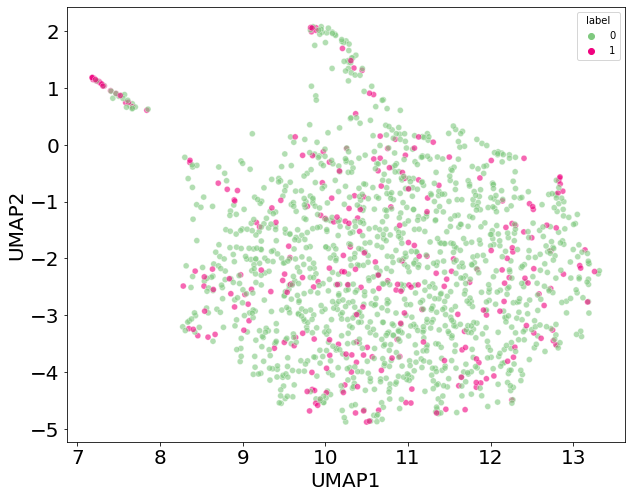

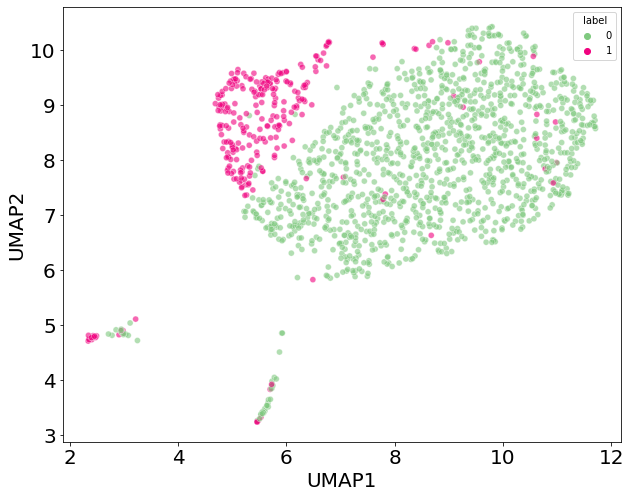

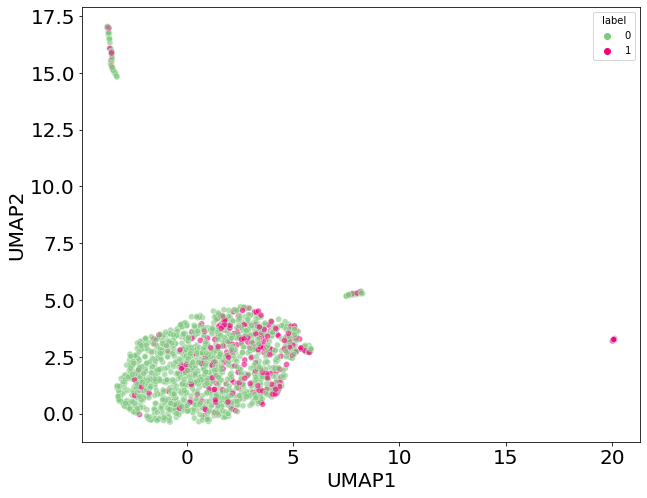

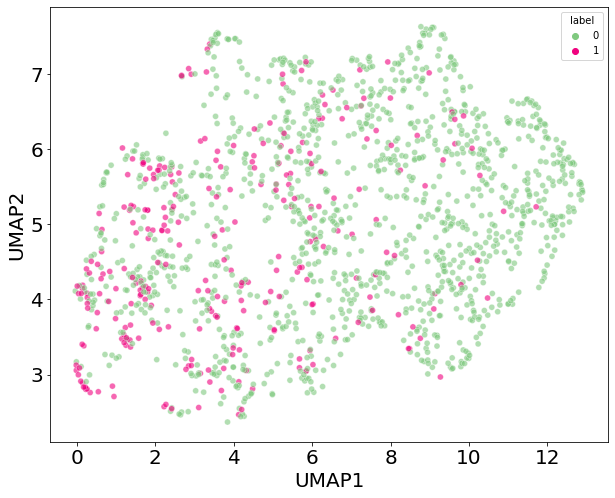

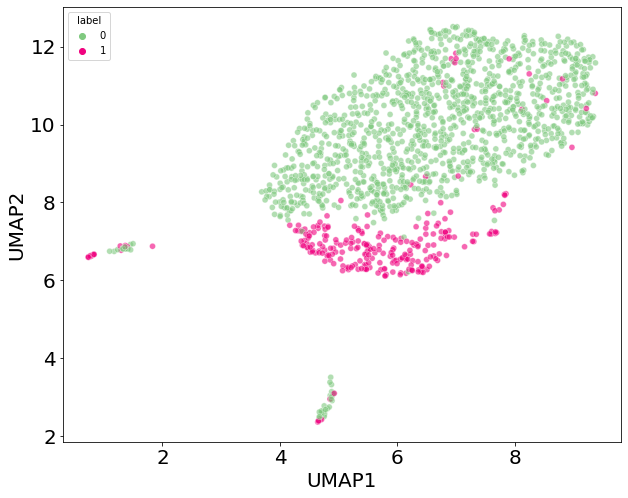

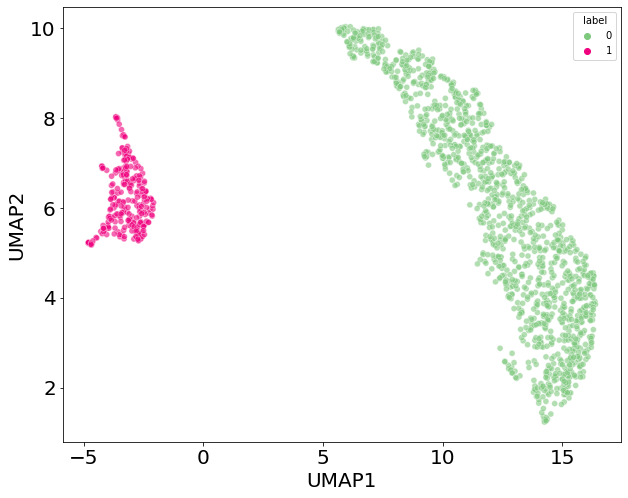

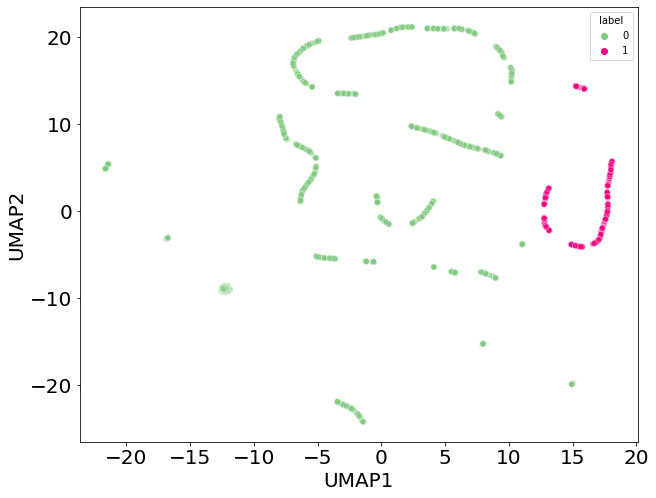

In [24]:
input_data = train_input
input_data_lable = y_train_input

vision_layer = [0,14,15,16,17,18,20]

for ind, layer in enumerate(vision_layer):
    if ind == 0:
        layer_output_array_0 = input_data[0].reshape(input_data[0].shape[0],-1) 
        layer_output_array_1 = input_data[1].reshape(input_data[1].shape[0],-1) 
        layer_output_array = np.concatenate((layer_output_array_0, layer_output_array_1),axis=1)
    else:
        layer_model = Model(inputs=loaded_model.input, outputs=loaded_model.layers[layer].output)
        layer_output_array = layer_model.predict(input_data)
        layer_output_array = layer_output_array.reshape(layer_output_array.shape[0],-1)

    feat_cols = ['seq'+str(i) for i in range(layer_output_array.shape[1])]
    
    df = pd.DataFrame(layer_output_array, columns=feat_cols)
    df['label'] = input_data_lable
    df['label'] = df['label'].apply(lambda i: str(int(i)))
    df2 = df.label.value_counts()
    print(df2)

    n_sne = df.shape[0]
    np.random.seed(12345) # for reproducibility
    rndperm = np.random.permutation(df.shape[0])

    print('UMAP start...')
    X_reduced = df.loc[rndperm[:n_sne],feat_cols].values
    reducer = umap.UMAP(random_state=12345)
    tsne_results = reducer.fit_transform(X_reduced)
    print('UMAP done...')     
        
    df_tsne = df.loc[rndperm[:n_sne],'label'].copy()
    df_tsne = df_tsne.to_frame()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]
    
    font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 18}
    
    figsize=10, 8
    figure, ax = plt.subplots(figsize=figsize)
    plt.tick_params(labelsize=20)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels] 
    
    color=plt.get_cmap('Accent')([0,5])

    sns.scatterplot(
        x="x-tsne", y="y-tsne",
        hue="label",
        palette=color,
        data=df_tsne,
        legend="full",
        alpha=0.6
    )
    
    plt.xlabel('UMAP1',font1, fontsize=20)
    plt.ylabel('UMAP2', font1, fontsize=20)
    plt.show()